# On Mnist

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as FA
# from torchsummary import summary
from torchvision import datasets, transforms


In [2]:

vis = False

def generate_pyramid(image, num_levels):
    pyramid = [image]
    for i in range(1, num_levels):
        downsampled_image = F.interpolate(pyramid[-1], scale_factor=0.5, mode='bilinear', align_corners=False)
        pyramid.append(downsampled_image)
    return pyramid


def gaussian_kernel(size, sigma):
    """Generate a 2D Gaussian kernel using meshgrid coordinates."""
    # Define the coordinate range based on the kernel size
    ax = torch.linspace(-(size - 1) / 2., (size - 1) / 2., size)
    xx, yy = torch.meshgrid(ax, ax)
    xx,yy=xx.to(device),yy.to(device)

    # Calculate the 2D Gaussian kernel
    kernel = torch.exp(-(xx**2 + yy**2) / (2 * sigma**2))

    # Normalize the kernel so that the sum of all its elements will be 1.
    kernel = kernel / torch.sum(kernel)

    return kernel

def apply_gaussian_blur(image, kernel_size, sigma):
    """Applies Gaussian blur to an image using a 2D Gaussian kernel."""
    kernel = gaussian_kernel(kernel_size, sigma).to(image.device)
    kernel = kernel.view(1, 1, kernel_size, kernel_size)  # Shape the kernel for convolution
    padding = kernel_size // 2
    return F.conv2d(image, kernel, padding=padding, groups=image.shape[1])

def compute_dog(image, kernel_size, sigma1, sigma2):
    """Computes the difference of Gaussians for an image."""
    blur1 = apply_gaussian_blur(image, kernel_size, sigma1)
    blur2 = apply_gaussian_blur(image, kernel_size, sigma2)
    dog = blur1 - blur2
    return dog



class CustomConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(CustomConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        # Learnable parameters for the standard deviations of the Gaussians
        self.log_std1 = nn.Parameter(torch.randn(out_channels, in_channels, 1, 1))  # Std for first Gaussian
        self.log_std2 = nn.Parameter(torch.randn(out_channels, in_channels, 1, 1))  # Std for second Gaussian

    def forward(self, x):
        std1 = torch.exp(self.log_std1)
        std2 = torch.exp(self.log_std2)

        dog = torch.zeros((x.size(0), self.out_channels, x.size(2), x.size(3)), device=x.device)

        for i in range(self.out_channels):
            for j in range(self.in_channels):
                dog[:, i:i+1] += compute_dog(x[:, j:j+1], kernel_size=self.kernel_size, sigma1=std1[i, j], sigma2=std2[i, j])

#         if vis:
#             plot_feature_maps(dog, title="DoG Result")

        return dog 

class SimpleCNN(nn.Module):
    def __init__(self, num_pyramid_levels=3):
        super(SimpleCNN, self).__init__()
        self.num_pyramid_levels = num_pyramid_levels

        # First custom convolutional layer
        self.convs = nn.ModuleList([CustomConv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2)
                                    for _ in range(num_pyramid_levels)])

        self.conv2 = nn.Conv2d(in_channels=32 * num_pyramid_levels, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)

        self.pool = nn.AdaptiveAvgPool2d((8, 8))
        self.global_max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc1 = nn.Linear(32, 10)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        pyramid = generate_pyramid(x, self.num_pyramid_levels)

        pyramid_features = []
        for i, level in enumerate(pyramid):
            features = self.convs[i](level)
            features = F.relu(features)

            if i > 0:
                features = F.interpolate(features, size=pyramid[0].shape[2:], mode='bilinear', align_corners=False)

            pyramid_features.append(features)

        combined_features = torch.cat(pyramid_features, dim=1)
        
        x = self.conv2(combined_features)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.global_max_pool(x)
        x = x.view(x.size(0), -1)
        # x = self.dropout(x)
        x = self.fc1(x)
#         x = nn.Softmax(x)

        return x





In [3]:

# Example input tensor with batch size 64, 1 channel, and image size 28x28


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(pytorch_total_params)

37450


In [4]:


trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

for epoch in range(10): # Loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # Backward pass and optimize
        loss.backward()


        optimizer.step()




        running_loss += loss.item()
        vis=False
        if i % 100 == 99:  # Print every 100 batches
            vis=True
            print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
            running_loss = 0.0

print("Finished Training")


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15831912.80it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 465920.85it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1019853.75it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1875975.26it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/opt/conda/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[1, 100] loss: 1.885
[1, 200] loss: 0.788
[1, 300] loss: 0.494
[1, 400] loss: 0.418
[1, 500] loss: 0.351
[1, 600] loss: 0.316
[1, 700] loss: 0.288
[1, 800] loss: 0.253
[1, 900] loss: 0.230
[2, 100] loss: 0.212
[2, 200] loss: 0.201
[2, 300] loss: 0.191
[2, 400] loss: 0.180
[2, 500] loss: 0.182
[2, 600] loss: 0.178
[2, 700] loss: 0.162
[2, 800] loss: 0.160
[2, 900] loss: 0.149
[3, 100] loss: 0.154
[3, 200] loss: 0.137
[3, 300] loss: 0.135
[3, 400] loss: 0.129
[3, 500] loss: 0.133
[3, 600] loss: 0.133
[3, 700] loss: 0.124
[3, 800] loss: 0.134
[3, 900] loss: 0.117
[4, 100] loss: 0.123
[4, 200] loss: 0.116
[4, 300] loss: 0.106
[4, 400] loss: 0.100
[4, 500] loss: 0.115
[4, 600] loss: 0.122
[4, 700] loss: 0.105
[4, 800] loss: 0.095
[4, 900] loss: 0.108
[5, 100] loss: 0.092
[5, 200] loss: 0.101
[5, 300] loss: 0.108
[5, 400] loss: 0.090
[5, 500] loss: 0.102
[5, 600] loss: 0.096
[5, 700] loss: 0.081
[5, 800] loss: 0.099
[5, 900] loss: 0.085
[6, 100] loss: 0.087
[6, 200] loss: 0.080
[6, 300] loss

In [6]:
torch.save(model, 'model.pth')

In [5]:

def test_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient calculation
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)

    # Calculate precision, recall, f1-score
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-Score: {f1:.4f}')

    return accuracy, precision, recall, f1
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)
accuracy, precision, recall, f1 = test_model(model, testloader)


Accuracy: 0.9827
Precision: 0.9827
Recall: 0.9826
F1-Score: 0.9826


test without learn

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torch.load('/kaggle/input/mnist_new/pytorch/default/1/model (1).pth', weights_only=False).to(device)


In [9]:

def test_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient calculation
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)

    # Calculate precision, recall,7 f1-score
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-Score: {f1:.4f}')

    return accuracy, precision, recall, f1
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)
accuracy, precision, recall, f1 = test_model(model, testloader)


Accuracy: 0.9827
Precision: 0.9827
Recall: 0.9826
F1-Score: 0.9826


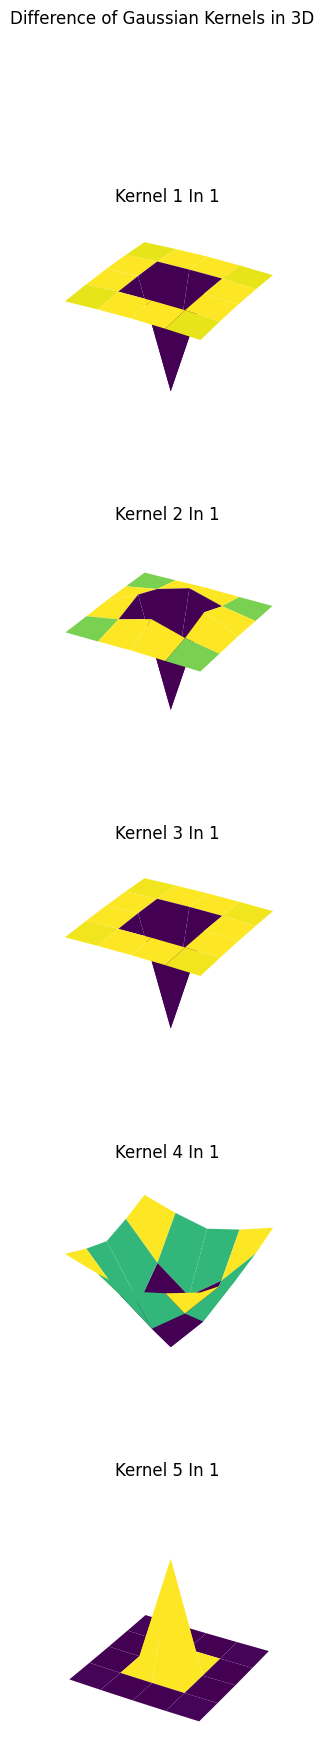

In [10]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
device='cpu'

def plot_kernels_3d(conv_layer, num_kernels=5):
    """
    Plots the learned kernels from a CustomConv2d layer after training in 3D.
    
    Args:
        conv_layer: The CustomConv2d layer from which to extract and plot the kernels.
        num_kernels: Number of kernels to plot (default: 5).
    """
    # Extract learned standard deviations
    std1 = torch.exp(conv_layer.log_std1).detach().cpu()
    std2 = torch.exp(conv_layer.log_std2).detach().cpu()

    # Create a grid of subplots
    num_out_channels = min(num_kernels, conv_layer.out_channels)
    
    fig = plt.figure(figsize=(conv_layer.in_channels * 4, num_out_channels * 4))
    fig.suptitle('Difference of Gaussian Kernels in 3D')

    # Loop through output channels (kernels)
    for i in range(num_out_channels):
        for j in range(conv_layer.in_channels):
            ax = fig.add_subplot(num_out_channels, conv_layer.in_channels, i * conv_layer.in_channels + j + 1, projection='3d')

            # Create the 2D Gaussian kernels based on learned std
            gaussian1 = gaussian_kernel(conv_layer.kernel_size, std1[i, j])
            gaussian2 = gaussian_kernel(conv_layer.kernel_size, std2[i, j])
            dog_kernel = (gaussian1 - gaussian2).cpu().numpy()

            # Generate X and Y coordinates for 3D plot
            x = np.linspace(-conv_layer.kernel_size // 2, conv_layer.kernel_size // 2, conv_layer.kernel_size)
            y = np.linspace(-conv_layer.kernel_size // 2, conv_layer.kernel_size // 2, conv_layer.kernel_size)
            x, y = np.meshgrid(x, y)

            # Plot the kernel in 3D
            ax.plot_surface(x, y, dog_kernel, cmap='viridis')

            ax.set_title(f'Kernel {i+1} In {j+1}')
            ax.set_zlim(dog_kernel.min(), dog_kernel.max())
            ax.axis('off')  # Hide axes for better visualization

    plt.show()

# Example usage after training:
# Assuming `model` is an instance of `SimpleCNN`
plot_kernels_3d(model.convs[0])


# On Med Mnist

In [3]:
pip install medmnist


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 2.2 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.6.0-py2.py3-none-any.whl size=117029 sha256=98be7e70100a40cad757c111ad2e4a29c5f6c9e4f7fa49e6d38fd4f5f6e3427b
  Stored in directory: /root/.cache/pip/wheels/d6/6d/5d/5b73fa0f46d01a793713f8859201361e9e581ced8c75e5c6a3
Successfully built fire
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt

import torchvision.transforms.functional as FA
from torchvision import transforms

# Import MedMNIST
import medmnist
from medmnist import INFO, Evaluator

vis = False

def generate_pyramid(image, num_levels):
    pyramid = [image]
    for i in range(1, num_levels):
        downsampled_image = F.interpolate(pyramid[-1], scale_factor=0.5, mode='bilinear', align_corners=False)
        pyramid.append(downsampled_image)
    return pyramid

def gaussian_kernel(size, sigma):
    """Generate a 2D Gaussian kernel using meshgrid coordinates."""
    ax = torch.linspace(-(size - 1) / 2., (size - 1) / 2., size)
    xx, yy = torch.meshgrid(ax, ax, indexing='ij')
    xx, yy = xx.to(device), yy.to(device)

    kernel = torch.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    kernel = kernel / torch.sum(kernel)

    return kernel

def apply_gaussian_blur(image, kernel_size, sigma):
    """Applies Gaussian blur to an image using a 2D Gaussian kernel."""
    kernel = gaussian_kernel(kernel_size, sigma).to(image.device)
    kernel = kernel.view(1, 1, kernel_size, kernel_size)  # Shape the kernel for convolution
    padding = kernel_size // 2
    return F.conv2d(image, kernel, padding=padding, groups=image.shape[1])

def compute_dog(image, kernel_size, sigma1, sigma2):
    """Computes the difference of Gaussians for an image."""
    blur1 = apply_gaussian_blur(image, kernel_size, sigma1)
    blur2 = apply_gaussian_blur(image, kernel_size, sigma2)
    dog = blur1 - blur2
    return dog

class CustomConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(CustomConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        # Learnable parameters for the standard deviations of the Gaussians
        self.log_std1 = nn.Parameter(torch.randn(out_channels, in_channels, 1, 1))  # Std for first Gaussian
        self.log_std2 = nn.Parameter(torch.randn(out_channels, in_channels, 1, 1))  # Std for second Gaussian

    def forward(self, x):
        std1 = torch.exp(self.log_std1)
        std2 = torch.exp(self.log_std2)

        dog = torch.zeros((x.size(0), self.out_channels, x.size(2), x.size(3)), device=x.device)

        for i in range(self.out_channels):
            for j in range(self.in_channels):
                dog[:, i:i+1] += compute_dog(
                    x[:, j:j+1],
                    kernel_size=self.kernel_size,
                    sigma1=std1[i, j],
                    sigma2=std2[i, j]
                )

        return dog 

class SimpleCNN(nn.Module):
    def __init__(self, num_pyramid_levels=3, num_classes=9):  # Updated num_classes
        super(SimpleCNN, self).__init__()
        self.num_pyramid_levels = num_pyramid_levels

        # First custom convolutional layer
        self.convs = nn.ModuleList([
            CustomConv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=2)
            for _ in range(num_pyramid_levels)
        ])

        self.conv2 = nn.Conv2d(in_channels=32 * num_pyramid_levels, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)

        self.pool = nn.AdaptiveAvgPool2d((8, 8))
        self.global_max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc1 = nn.Linear(32, num_classes)  # Updated num_classes
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        pyramid = generate_pyramid(x, self.num_pyramid_levels)

        pyramid_features = []
        for i, level in enumerate(pyramid):
            features = self.convs[i](level)
            features = F.relu(features)

            if i > 0:
                features = F.interpolate(
                    features,
                    size=pyramid[0].shape[2:],
                    mode='bilinear',
                    align_corners=False
                )

            pyramid_features.append(features)

        combined_features = torch.cat(pyramid_features, dim=1)
        
        x = self.conv2(combined_features)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.global_max_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)

        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Update num_classes based on dataset
num_classes = 9  # For PathMNIST
model = SimpleCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Get dataset info
data_flag = 'pathmnist'  # Choose the dataset you want to use
download = True

info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# Since MedMNIST datasets may have different image sizes and channels, adjust transforms accordingly
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


# Load datasets
train_dataset = DataClass(split='train', transform=transform, download=download)
val_dataset = DataClass(split='val', transform=transform, download=download)
test_dataset = DataClass(split='test', transform=transform, download=download)

# Create DataLoaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total trainable parameters: {pytorch_total_params}')




100%|██████████| 205615438/205615438 [00:07<00:00, 26556176.19it/s]


Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Total trainable parameters: 37801


In [ ]:
# Training loop
for epoch in range(10):  # Number of epochs
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data  # data is a tuple: (images, labels)
        labels = labels.squeeze().long()
        inputs, labels = inputs.to(device), labels.to(device)


        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:  # Print every 100 batches
            print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
            running_loss = 0.0

print("Finished Training")



[1, 100] loss: 1.809
[1, 200] loss: 1.286
[1, 300] loss: 1.141
[1, 400] loss: 1.043
[1, 500] loss: 1.007
[1, 600] loss: 0.962
[1, 700] loss: 0.927
[1, 800] loss: 0.889
[1, 900] loss: 0.886
[1, 1000] loss: 0.832
[1, 1100] loss: 0.811
[1, 1200] loss: 0.775
[1, 1300] loss: 0.743
[1, 1400] loss: 0.713
[2, 100] loss: 0.666
[2, 200] loss: 0.675
[2, 300] loss: 0.638
[2, 400] loss: 0.623
[2, 500] loss: 0.607
[2, 600] loss: 0.625
[2, 700] loss: 0.568
[2, 800] loss: 0.580
[2, 900] loss: 0.577
[2, 1000] loss: 0.581
[2, 1100] loss: 0.551
[2, 1200] loss: 0.542
[2, 1300] loss: 0.515
[2, 1400] loss: 0.520
[3, 100] loss: 0.506
[3, 200] loss: 0.508
[3, 300] loss: 0.505
[3, 400] loss: 0.495
[3, 500] loss: 0.480
[3, 600] loss: 0.482
[3, 700] loss: 0.463
[3, 800] loss: 0.470
[3, 900] loss: 0.489
[3, 1000] loss: 0.480
[3, 1100] loss: 0.462
[3, 1200] loss: 0.458
[3, 1300] loss: 0.455
[3, 1400] loss: 0.459
[4, 100] loss: 0.443
[4, 200] loss: 0.442
[4, 300] loss: 0.439
[4, 400] loss: 0.438
[4, 500] loss: 0.42

In [ ]:
def test_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient calculation
        for data in test_loader:
            inputs, labels = data  # data is a tuple: (images, labels)

            labels = labels.squeeze().long()
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)

    # Calculate precision, recall, f1-score
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='macro', zero_division=0
    )

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-Score: {f1:.4f}')

    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = test_model(model, test_loader)